In [1]:
cd ..

In [2]:
# basic imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt

# tensorflow imports
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# own imports
from flow import load_data, select_dates, sales_to_money, select_final_day, create_submission, select_day_nums
from evaluation import Referee, RapidReferee, CrossValiDataGenerator
from agent import KDayMeanTimesWeeklyPattern
from train import BatchCreator

In [3]:
os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions/'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for MacOS TF bug

# General settings for figures
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 13})  # 12, 16
plt.rcParams["savefig.bbox"] = 'tight'

# Top Down for M5Forecast - Accuracy
This notebook investigates the Top Down approach for the M5Forecast - Accuracy challenge. Here, the aggregated sales of the stores are predicted directly by the model, instead of calculating the sales by aggregating product-level predictions.  

Here a simple MLP and 1D CNN is trained as proof of concept, and baseline for more complex networks. 

In [4]:
# Load data
calendar, sales_train_validation, sell_prices = load_data()

# Set up generator
cv_generator = CrossValiDataGenerator(sales_train_validation)
sales_train, sales_true = cv_generator.get_train_val_split(fold=10, train_size=-1)

# create referee for fold 10
ref = Referee(sales_true, sales_train, sell_prices, calendar)

Calculating weights for each level...
Calculating scale for each level...
Finished setup.


## Explore aggregated sales - store level

In [5]:
# calculate aggregated sales: per store
sales_train_aggregated = sales_train.groupby(['store_id']).sum()
sales_true_aggregated = sales_true.groupby(['store_id']).sum()
sales_train_aggregated.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1624,d_1625,d_1626,d_1627,d_1628,d_1629,d_1630,d_1631,d_1632,d_1633
store_id,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,...,5132,5631,5919,4424,3805,3971,4097,4598,5133,5655
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,...,3663,5294,4974,3134,3173,3216,3494,4059,5344,4960
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,...,6680,7239,7846,6598,6063,6228,6153,6354,7397,8226
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,...,2498,2736,2710,2641,2290,2328,2587,2595,2533,2765
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,...,3086,3841,4430,3449,3123,3428,3193,3539,4027,4416


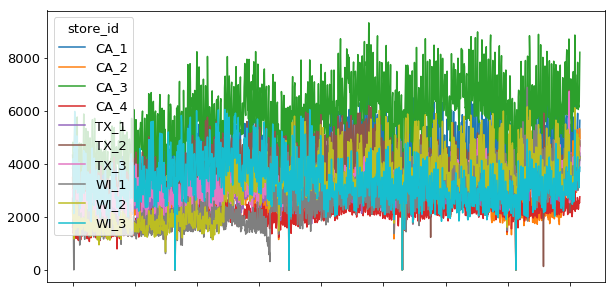

In [6]:
sales_train_aggregated.T.plot()
plt.show()

## Proof of concept - model training
Below the necessary steps are taken to train a simple model which is tasked to predict the following 28 days, based on the 28 days preceding it. The model is tasked to predict the aggregated sales of the 10 stores directly, so have 280 output values. For simplicity the input consists of the aggregated sales of these same stores. No other context is provided, like the day of the week or special events. 

In [7]:
def preprocess(sales, prices=None, calendar=None, norm=None):
    """Convert sales to a suitable format for the BatchCreator"""
    # prices and calendar inputs are for compatibility
    
    # Calculate aggregated sales
    df = sales.groupby(['store_id']).sum()
    
    # Transpose sales such that d_num_start, ... is the index
    df = df.T
    
    # Normalize
    if norm is None:
        norm = df.max().max()
    df /= norm
    
    return df, norm

In [8]:
# Get suitable train df
train_df, train_norm = preprocess(sales_train)
features = train_df.columns

# Set up batch creator
window_in, window_out = 28, 28
batch_creator = BatchCreator(df=train_df, features=features, labels=features, 
                             window_in=window_in, window_out=window_out)

# Test if batch creator works
x, y = next(batch_creator.flow())
print("Input shape: {}, output shape: {}".format(x.shape, y.shape))
batch_creator.on_epoch_end()  # reset generator

Input shape: (32, 28, 10), output shape: (32, 28, 10)


In [9]:
def get_model(inp_shape, out_shape):
    # clear previous sessions
    K.clear_session()

    # add first layer with correct input size
    inp = Input(shape=inp_shape, name="input")
    # flatten the 28x10 input days x features
    x = Flatten()(inp)
    
    # build network
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    # add output and build model
    x = Dense(np.prod(out_shape), activation='linear')(x)
    out = Reshape(out_shape, name='output')(x)
    
    model = Model(inputs=inp, outputs=out)
    model.compile(loss='MSE', optimizer='adam', metrics=['MSE'])
    
    return model

model = get_model(inp_shape=(window_in, batch_creator.n_features), 
                  out_shape=(window_out, batch_creator.n_labels))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 10)]          0         
_________________________________________________________________
flatten (Flatten)            (None, 280)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               35968     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 280)               9240      
_________________________________________________________________
output (Reshape)             (None, 28, 10)            0     

In [10]:
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class Logger(Callback):
    def __init__(self, ref, cv_generator, prices=None, calendar=None, train_norm=None, 
                 features=None, labels=None, agent=None, folds=None, window_in=28,
                 preprocess_func=None, update_plot=True):
        self.ref = ref
        self.cv_generator = cv_generator
        self.prices = prices
        self.calendar = calendar
        self.train_norm = train_norm
        self.features = features
        self.labels = labels
        self.folds = folds
        self.agent = agent
        self.window_in = window_in
        self.preprocess_func = preprocess_func
        self.update_plot = update_plot
        
        self.losses = []
        self.val_metrics = []
        self.best_wrmsse = np.inf
        self.best_model = None
    
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
    
    def on_epoch_end(self, batch, logs={}):
        mean_wrmsse, wrmsses = self.validate()
        self.val_metrics.append([len(self.losses), mean_wrmsse])
        if mean_wrmsse > self.best_wrmsse:
            self.best_wrmsse = mean_wrmsse
            self.best_model = self.model.get_weights()
        if self.update_plot:
            self.plot()
           
    def validate(self):
        ls = []

        for fold in self.folds:
            sales_train, sales_true = self.cv_generator.get_train_val_split(fold=fold, train_size=self.window_in)

            sales_true_aggregated = sales_true.groupby(['store_id']).sum()
            train_df, norm = self.preprocess_func(sales_train, prices=self.prices,
                                                  calendar=self.calendar, norm=self.train_norm)
            
            # select days to predict
            val_day_nums = select_day_nums(sales_true_aggregated)
            sales_pred = self.agent.predict(train_df, val_day_nums)

            store_WRMSSE = self.ref.calc_WRMSSE(sales_true=sales_true_aggregated, sales_pred=sales_pred.T, 
                                                groupby=None, weights=ref.weights[3], scale=ref.scales[3])
            ls.append(store_WRMSSE)
        
        return np.mean(ls), ls
    
    def plot(self, clear=True):
        if clear: 
            clear_output()
        
        N = len(self.losses)
        train_loss_plt, = plt.plot(range(0, N), self.losses)
        val_plt, = plt.plot(*np.array(self.val_metrics).T)
        plt.legend((train_loss_plt, val_plt), 
                   ('training loss', 'validation WRMSSE'))
        plt.show()

In [11]:
from agent import AgentBase

class AggregateAgent(AgentBase):
    """Agent to predict sales on aggregate level"""
    def __init__(self, model, train_norm, features, window_in=28):
        self.model = model
        self.train_norm = train_norm
        self.features = features
        self.window_in = window_in
    
    def predict(self, train_df, val_day_nums):
        # select date columns
        final_inp_day = min(val_day_nums) - 1
        first_inp_day = final_inp_day - self.window_in + 1
        inp_day_idx = ['d_%d'%d for d in range(first_inp_day, final_inp_day+1)]
        out_day_idx = ['d_%d'%d for d in val_day_nums]
        
        # predict (wrap and unwrap into 'batch' of one)
        X = np.array([train_df.loc[inp_day_idx, self.features].values])
        y_pred = model.predict(X)[0]
        
        # reshape, set columns and indices, and de-normalise
        sales_pred = pd.DataFrame(y_pred * self.train_norm, 
                                  index=out_day_idx, columns=self.features)
        return sales_pred

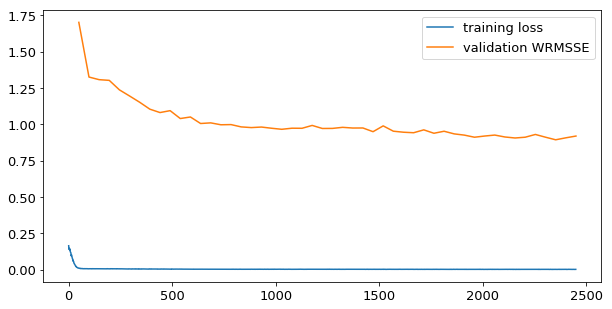

49/49 [==============================] - 6s 115ms/step - loss: 0.0024 - MSE: 0.0024


In [12]:
logger = Logger(ref=ref, cv_generator=cv_generator, train_norm=train_norm, features=features,
                agent=AggregateAgent(model=model, train_norm=train_norm, features=features, window_in=28),
                preprocess_func=preprocess, folds = np.arange(1, 1+10))

history = model.fit(batch_creator.flow(), epochs=50,
                    steps_per_epoch=batch_creator.n // batch_creator.batch_size,
                    callbacks=[logger])

## Proof of concept - model predictions
Model predictions are the aggregated sales for a 28 day period for the 10 stores. To test the predictions, these have to be de-normalised and compared to the true sales. 

In [14]:
# select days to predict
val_day_nums = select_day_nums(sales_true_aggregated)
# setup agent with trained model
agent = AggregateAgent(model=model, train_norm=train_norm, features=features)

In [15]:
# prediction
sales_pred = agent.predict(train_df, val_day_nums)
sales_pred

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
d_1634,4563.064453,3103.109375,7162.757324,2698.050537,3406.699463,4446.250488,3745.179199,3221.676025,4072.576172,3021.170898
d_1635,3899.617920,2475.104248,6373.685059,2361.899658,2975.953369,3775.063965,3218.796387,2841.205811,3804.855225,2542.474121
d_1636,3623.171631,2572.610107,5888.971680,2308.809082,2914.296143,3663.062256,3126.912354,2984.945068,3777.915771,2473.774414
d_1637,4030.854980,2747.657959,6013.342773,2349.888916,2826.951416,3654.012207,3235.297852,3065.179932,3757.786621,2605.981445
d_1638,4685.405762,3245.664795,6724.654785,2509.384277,3240.247559,4150.066895,3516.176514,3562.932861,3937.987549,2954.427246
d_1639,5494.511719,3812.551514,7362.067383,2563.564453,3580.321289,4763.940430,3700.086914,3981.912842,4154.512695,3322.344971
d_1640,5517.937988,3729.499268,7523.135742,2797.644287,3707.803467,4821.391113,4091.872803,3826.037109,4149.664062,3295.252197
d_1641,4701.956055,3000.035400,6972.585938,2651.339844,3177.542969,4306.461426,3583.527344,3130.622070,3775.537598,2891.157471
d_1642,4041.809814,2608.707520,6374.148926,2419.615723,2895.585938,3682.270508,3283.829346,2939.577637,3725.813721,2601.809814
d_1643,3896.979980,2607.641113,6207.799316,2350.426025,2755.578369,3635.708008,3046.352783,2900.521240,3901.356201,2612.224609


In [16]:
# evaluate model for final 10 folds
WRMSSE_mean, WRMSSE_list = logger.validate()
print("Mean WRMSSE level 3: {}".format(WRMSSE_mean))

Mean WRMSSE level 3: 0.9192078032591133


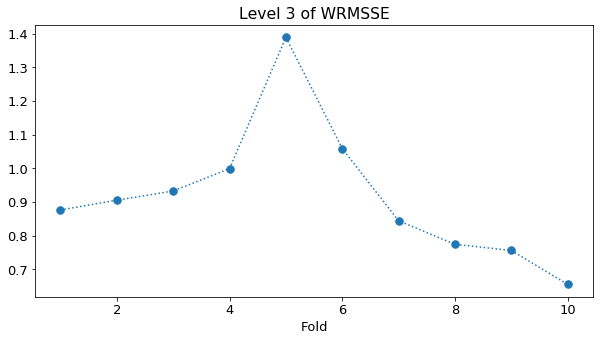

In [17]:
f, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(WRMSSE_list))+1, WRMSSE_list, '.:', ms=15)
ax.set_xlabel("Fold")
ax.set_title("Level 3 of WRMSSE")
plt.show()

## CNN

In [35]:
def get_model(inp_shape, out_shape):
    # clear previous sessions
    K.clear_session()

    # add first layer with correct input size
    inp = Input(shape=inp_shape, name="input")
    x = Reshape((np.prod(inp_shape), 1))(inp)
    
    x = Conv1D( 8, kernel_size=3, padding="same", activation='relu')(x)
    x = Conv1D(16, kernel_size=3, padding="same", activation='relu')(x)
    x = Conv1D(32, kernel_size=3, padding="same", activation='relu')(x)

    out = Conv1D(1, kernel_size=1, activation='linear', name='output')(x)
    out = Reshape(out_shape)(out)
    
    model = Model(inputs=inp, outputs=out)

    model.compile(loss='MSE', optimizer='adam', metrics=['MSE'])
    
    return model

model = get_model(inp_shape=(window_in, batch_creator.n_features), 
                  out_shape=(window_out, batch_creator.n_labels))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 10)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 280, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 280, 8)            32        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 280, 16)           400       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 280, 32)           1568      
_________________________________________________________________
output (Conv1D)              (None, 280, 1)            33        
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 10)            0     

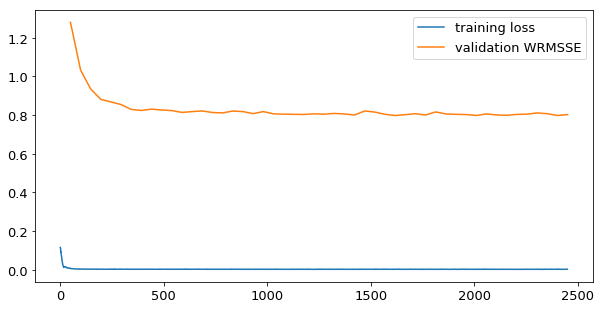

49/49 [==============================] - 6s 130ms/step - loss: 0.0027 - MSE: 0.0027


In [36]:
logger = Logger(ref=ref, cv_generator=cv_generator, train_norm=train_norm, features=features,
                agent=AggregateAgent(model=model, train_norm=train_norm, features=features, window_in=28),
                preprocess_func=preprocess, folds = np.arange(1, 1+10))

history = model.fit(batch_creator.flow(), epochs=50,
                    steps_per_epoch=batch_creator.n // batch_creator.batch_size,
                    callbacks=[logger])

## CNN - model prediction

In [37]:
# select days to predict
val_day_nums = select_day_nums(sales_true_aggregated)
agent = AggregateAgent(model=model, train_norm=train_norm, features=features, window_in=28)

In [38]:
# predictions
sales_pred = agent.predict(train_df, val_day_nums)
sales_pred

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
d_1634,4133.472656,2944.282715,6079.370117,2290.785156,2983.469482,3530.319092,3285.400391,2765.938965,3755.086914,2916.280029
d_1635,4109.354004,2892.961426,5893.637207,2271.997559,2938.537842,3328.516846,3147.052734,3096.956787,3340.572998,2932.863525
d_1636,3887.417480,2978.290527,5512.375977,2092.872314,2880.208008,3383.301270,3150.639404,2987.903809,3173.682617,2710.006348
d_1637,3879.294434,2866.298828,5875.600098,2165.900146,2868.698242,3406.826416,3182.896729,3039.013672,3237.943848,2717.478760
d_1638,4327.713867,3484.860352,6163.822754,2436.147949,2982.879395,3608.677734,3417.025146,3447.956787,3348.960938,2532.887695
d_1639,4951.937500,4422.483398,7041.058105,2650.128418,3350.930664,4143.818848,3712.642334,3839.806152,3806.350098,3206.563721
d_1640,5344.072754,4472.052734,7358.847656,2705.209717,3434.404541,4068.012207,3903.750488,3746.778564,3401.750488,3348.672607
d_1641,4007.052979,2977.127197,6132.939453,2329.877686,2960.658691,3453.309570,3322.864014,3140.576904,3408.078125,2766.511475
d_1642,4040.478271,2902.148438,5930.746094,2245.384033,2871.771240,3192.263428,2957.911377,3076.012207,3270.415771,2809.639648
d_1643,4504.239258,3286.952637,6736.050293,2409.250732,3304.862549,3630.494629,3726.260498,3333.919678,4004.324463,3095.253174


In [39]:
# evaluate model on final 10 folds
WRMSSE_mean, WRMSSE_list = logger.validate()
print("Mean WRMSSE level 3: {}".format(WRMSSE_mean))

Mean WRMSSE level 3: 0.8030072408406245


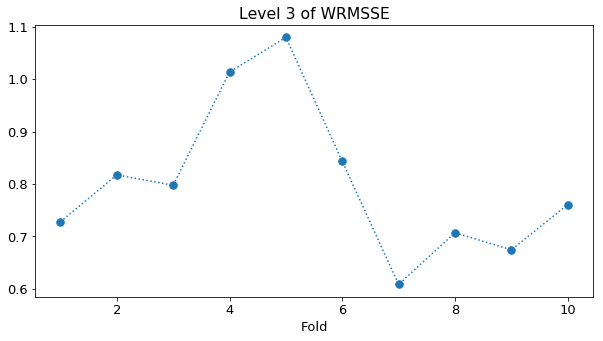

In [40]:
f, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(WRMSSE_list))+1, WRMSSE_list, '.:', ms=15)
ax.set_xlabel("Fold")
ax.set_title("Level 3 of WRMSSE")
plt.show()